In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm, trange
tqdm.pandas()
%cd /home/jeroen/repos/traffic-scheduling/
from ordering.util import plot_schedule
from network.generate_network import generate_grid_network
from network.util import draw_network
from network.exact import solve

/home/jeroen/repos/traffic-scheduling


In [2]:
vehicle_l = 2
vehicle_w = 1

## Lane arrivals

In [3]:
def cumulate(lane):
    def inner(n):
        lengths, gaps = lane(n)
        shifted = np.roll(lengths, 1); shifted[0] = 0
        releases = np.cumsum(gaps + shifted)
        return {'length': [lengths], 'release': [releases]}
    return inner

In [4]:
def append(instance, lane):
    instance['length'].append(lane['length'][0])
    instance['release'].append(lane['release'][0])
    return instance

In [5]:
lane = {}
lane[0] = lambda n: (np.repeat(vehicle_l, n), rng.uniform(1, 4, size=(n)))
lane[1] = lambda n: (np.repeat(vehicle_l, n), rng.uniform(1, 8, size=(n)))
lane[2] = lambda n: (np.repeat(vehicle_l, n), rng.exponential(scale=4, size=(n)))
lane[3] = lambda n: (np.repeat(vehicle_l, n), rng.exponential(scale=6, size=(n)))

def multimodal(n):
    p = rng.binomial(1, 0.3, size=(n))
    return (1-p) * rng.exponential(scale=1, size=(n)) + p * rng.exponential(scale=10, size=(n))

lane[4] = lambda n: (np.repeat(vehicle_l, n), multimodal(n))

Show some samples of these distributions.

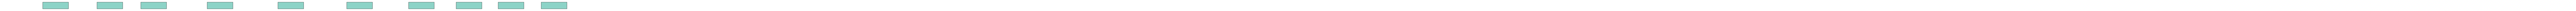

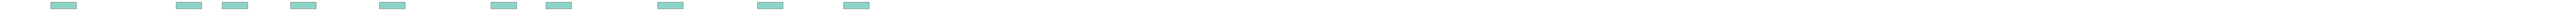

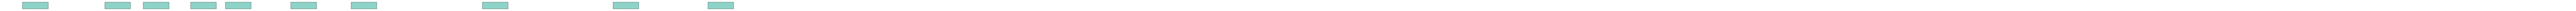

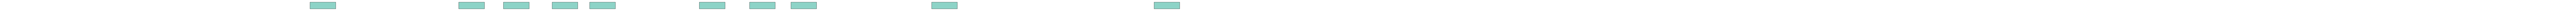

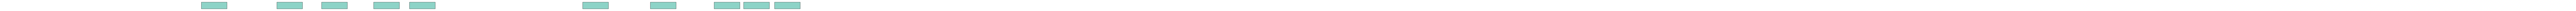

In [13]:
n_samples = 10
end = 200
for i in range(5):
    instance = cumulate(lane[i])(n_samples)
    plot_schedule(instance, clean=True, custom_end_time=end)

## Network and routes

We start by defining three networks of increasing size.

In [14]:
G, routes = {}, {}
G[1], routes[1] = generate_grid_network(2, 1)
G[2], routes[2] = generate_grid_network(2, 2)
G[3], routes[3] = generate_grid_network(6, 6)

Next, we assign arrival distributions to classes of the networks.

### Symmetric

We might need to apply some kind of time-shifting, because some lanes only start interfering with each other after some time.

In [15]:
def measure(graph, routes, lane, n_vehicles, log=False):
    instance = {
        'G': graph,
        'route': routes,
        'switch': vehicle_l - vehicle_w,
        'length': [], 'release': []
    }
    for l in range(len(routes)):
        instance = append(instance, cumulate(lane)(n_vehicles))
    
    start = time.time()
    solve(instance, consolelog=log)
    return time.time() - start

In [16]:
results = pd.DataFrame()

graph_id = 3
lane_id = 4
n_vehicles = 30 # per lane
n_instances = 1

results['running_time'] = [measure(G[graph_id], routes[graph_id], lane[lane_id], n_vehicles, log=True) for _ in trange(n_instances)]

results.mean()

  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-22
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i5-13600K, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 69756 rows, 34920 columns and 203952 nonzeros
Model fingerprint: 0xbafed1fd
Variable types: 2520 continuous, 32400 integer (32400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+03]
Presolve removed 372 rows and 12 columns
Presolve time: 0.14s
Presolved: 69384 rows, 34908 columns, 203568 nonzeros
Variable types: 2508 continuous, 32400 integer (32400 binary)
Found heuristic solution: objective 649250.88953

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model

running_time    88.978213
dtype: float64